# Predicting User Satisfaction with Amazon Alexa
## Final Project for Machine Learning INFO 656 at Pratt Institute
### By Elena Korshakova and Diedre Brown


#### Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import sklearn
sklearn.__version__>="0.20"
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocesing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticResgression, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

ModuleNotFoundError: No module named 'sklearn.preprocesing'

In [3]:
import nltk
nltk.download("words")

[nltk_data] Downloading package words to
[nltk_data]     /Users/diedrebrown/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
# pip install spacy

     |████████████████████████████████| 10.0 MB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 286 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 262 kB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 878 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import string
import spacy
#spacy_en = spacy.load("en_core_web_sm")

In [5]:
from spacy.lang.en import English
nlp = English() # use directly

In [4]:
%matplotlib inline
# makes inline plots to have better quality
%config InlineBackend.figure_format = 'svg'
# Set the default style
plt.style.use("seaborn")

In [5]:
pd.set_option('mode.chained_assignment', None)

## Loading the data

<b>Training dataset: [Amazon Echo Dot 2 Reviews Dataset](https://www.kaggle.com/PromptCloudHQ/amazon-echo-dot-2-reviews-dataset)</b>


<b>Test dataset: [Amazon Alexa Reviews](https://www.kaggle.com/sid321axn/amazon-alexa-reviews)</b>

In [6]:
df_train_raw = pd.read_csv("data/reviews_2017.csv")
df_test_raw = pd.read_csv("data/reviews_2018.tsv", sep = "\t")

FileNotFoundError: [Errno 2] File data/reviews_2017.csv does not exist: 'data/reviews_2017.csv'

In [7]:
df_train_raw.head()

,Pageurl,Title,Review Text,Review Color,User Verified,Review Date,Review Useful Count,Configuration Text,Rating,Declaration Text
0,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Three Stars,Not great speakers,Black,Verified Purchase,10/3/2017,NaN,Echo Dot,3,NaN
1,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Four Stars,Great little gagit,White,Verified Purchase,9/26/2017,NaN,Echo Dot,4,NaN
2,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Awesome!,Awesome 👏🏽,White,Verified Purchase,9/8/2017,NaN,Echo Dot,5,NaN
3,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Five Stars,Love my Echo,Black,Verified Purchase,10/19/2017,NaN,Echo Dot,5,NaN
4,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Five Stars,Great device,Black,Verified Purchase,9/17/2017,NaN,Echo Dot,5,NaN


In [8]:
df_train = df_train_raw[['Review Text', 'Rating']]
df_train.columns = ['review', 'rating']

In [9]:
df_train.head()

,review,rating
0,Not great speakers,3
1,Great little gagit,4
2,Awesome 👏🏽,5
3,Love my Echo,5
4,Great device,5


In [10]:
df_train.shape

(6855, 2)

In [11]:
df_test_raw.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [12]:
df_test = df_test_raw[['verified_reviews', 'rating']]
df_test.columns = ['review', 'rating']

In [13]:
df_test.head()

,review,rating
0,Love my Echo!,5
1,Loved it!,5
2,"Sometimes while playing a game, you can answer...",4
3,I have had a lot of fun with this thing. My 4 ...,5
4,Music,5


In [14]:
df_test.shape

(3150, 2)

## Raw data exploration

### Training dataset

In [15]:
# Drop url column and rename columns
df_train_raw = df_train_raw.drop(columns = ['Pageurl'])
df_train_raw.columns = ['title', 'review', 'review_color', 'user_virified', 'date', 
                        'useful_count', 'config', 'rating', 'declaration_text']
df_train_raw.fillna(0, inplace=True)
df_train_raw.head()

,title,review,review_color,user_virified,date,useful_count,config,rating,declaration_text
0,Three Stars,Not great speakers,Black,Verified Purchase,10/3/2017,0.0,Echo Dot,3,0
1,Four Stars,Great little gagit,White,Verified Purchase,9/26/2017,0.0,Echo Dot,4,0
2,Awesome!,Awesome 👏🏽,White,Verified Purchase,9/8/2017,0.0,Echo Dot,5,0
3,Five Stars,Love my Echo,Black,Verified Purchase,10/19/2017,0.0,Echo Dot,5,0
4,Five Stars,Great device,Black,Verified Purchase,9/17/2017,0.0,Echo Dot,5,0


In [16]:
df_train_raw.shape

(6855, 9)

In [17]:
df_train_raw['review_color'].value_counts()

Black    5410
White    1445
Name: review_color, dtype: int64

In [18]:
df_train_raw['config'].value_counts()

Echo Dot                   6854
Echo Dot + Vaux Speaker       1
Name: config, dtype: int64

Majority of the reviews are about Echo Dot device and only one review is about Echo Dot + Vaux Speaker.

In [19]:
df_train_raw['useful_count'].value_counts()

0.0      6827
2.0        22
3.0         4
284.0       1
138.0       1
Name: useful_count, dtype: int64

Only 28 reviews out of 6855 were upvoted (marked as useful) by other users.

In [20]:
# Convert date column to datetime format
df_train_raw['date'] = pd.to_datetime(df_train_raw['date'])

# Extract year and month-day
df_train_raw['year'] = df_train_raw['date'].dt.year
df_train_raw['mm-dd'] = df_train_raw['date'].dt.strftime('%m-%d')

In [21]:
df_train_raw.head()

,title,review,review_color,user_virified,date,useful_count,config,rating,declaration_text,year,mm-dd
0,Three Stars,Not great speakers,Black,Verified Purchase,2017-10-03,0.0,Echo Dot,3,0,2017,10-03
1,Four Stars,Great little gagit,White,Verified Purchase,2017-09-26,0.0,Echo Dot,4,0,2017,09-26
2,Awesome!,Awesome 👏🏽,White,Verified Purchase,2017-09-08,0.0,Echo Dot,5,0,2017,09-08
3,Five Stars,Love my Echo,Black,Verified Purchase,2017-10-19,0.0,Echo Dot,5,0,2017,10-19
4,Five Stars,Great device,Black,Verified Purchase,2017-09-17,0.0,Echo Dot,5,0,2017,09-17


In [22]:
df_train_raw['year'].unique()

array([2017])

Reviews from the training dataset were collected in September and October 2017

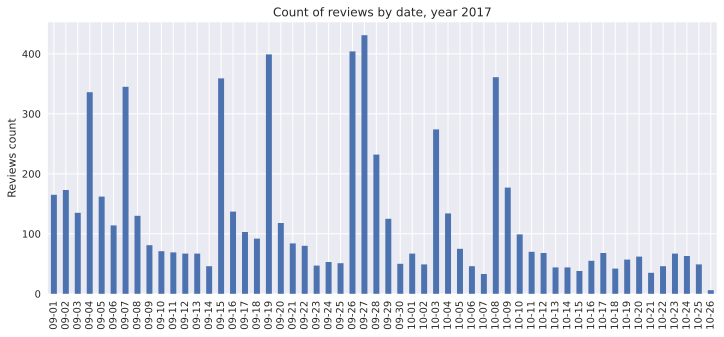

In [23]:
fig = plt.figure(figsize=(12,5))
df_train_raw['mm-dd'].value_counts().sort_index().plot(kind = 'bar')
plt.ylabel("Reviews count")
plt.title("Count of reviews by date, year 2017")
plt.savefig('img/2017-reviews_by_date.png', dpi=100)
plt.show()


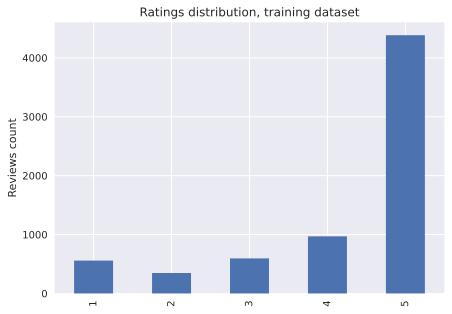

In [24]:
fig = plt.figure(figsize=(7,5))
df_train_raw['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.ylabel("Reviews count")
plt.title("Ratings distribution, training dataset")
plt.savefig('img/2017-ratings_distribution.png', dpi=100)
plt.show()

People mostly leave positive reviews about Echo Dot.

### Test dataset

In [25]:
df_test_raw.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [26]:
df_test_raw.shape

(3150, 5)

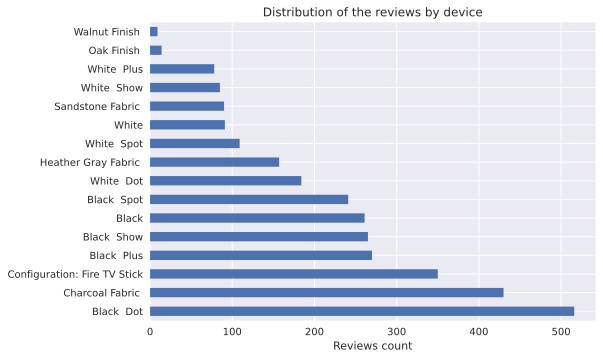

In [27]:
df_test_raw['variation'].value_counts().plot(kind = 'barh')
plt.xlabel("Reviews count")
plt.title("Distribution of the reviews by device")
plt.savefig('img/2018-reviews_by_device.png', dpi=100)
plt.show()

Reiews in the test dataset are about different variations of Echo Dot device and other devices like Fire TV Stick. The most popular device is Black Dot.

In [28]:
# Convert date column to datetime format
df_test_raw['date'] = pd.to_datetime(df_test_raw['date'])

# Extract year and month-day
df_test_raw['year'] = df_test_raw['date'].dt.year
df_test_raw['mm-dd'] = df_test_raw['date'].dt.strftime('%m-%d')

In [29]:
df_test_raw.head()

,rating,date,variation,verified_reviews,feedback,year,mm-dd
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,2018,07-31
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,2018,07-31
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,2018,07-31
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,2018,07-31
4,5,2018-07-31,Charcoal Fabric,Music,1,2018,07-31


In [30]:
df_test_raw['year'].unique()

array([2018])

Reviews from the test dataset were collected in 2018. The majority of reviews were collected in June 2018.

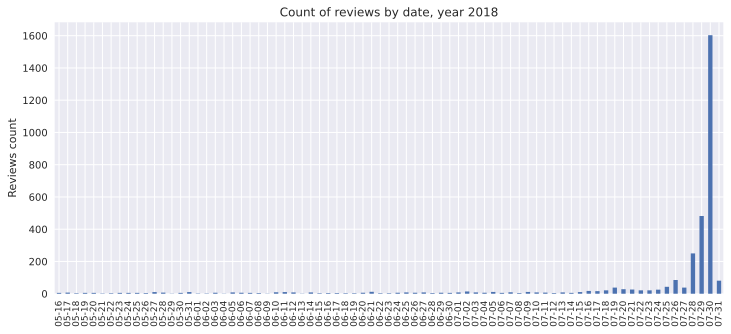

In [31]:
fig = plt.figure(figsize=(12,5))
df_test_raw['mm-dd'].value_counts().sort_index().plot(kind = 'bar')
plt.tick_params(axis='x', which='both', labelsize=9)
plt.ylabel("Reviews count")
plt.title("Count of reviews by date, year 2018")
plt.savefig('img/2018-reviews_by_date.png', dpi=100)
plt.show()

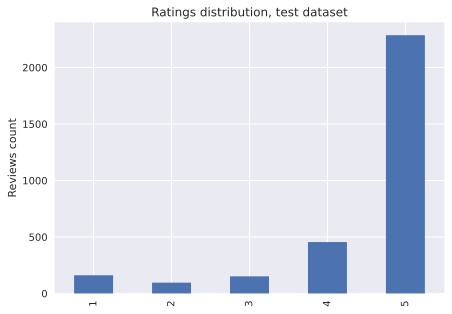

In [32]:
fig = plt.figure(figsize=(7,5))
df_test_raw['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.ylabel("Reviews count")
plt.title("Ratings distribution, test dataset")
plt.savefig('img/2018-ratings_distribution.png', dpi=100)
plt.show()

Rating distribution is very similar to the data from 2017.

## Reviews cleaning

In [33]:
def preprocess_reviews(df_raw, stop_words: set, eng_words: set):
    """Perform lemmatization, remove stopwords, punctuation, non-english words."""
    def delete_words(row): 
        """Delete stop words, punctuation, and non-english words from a review."""
        row = row.split()
        result_row = [word for word in row 
                      if word not in stop_words
                      and word in eng_words]
        return result_row
    
    df = df_raw.copy()
    
    # Lowercase reviews
    df['review'] = df.apply(lambda row: str(row['review']).lower(), axis=1)
    
    # Lemmatization
    df['review'] = df['review'].apply(lambda row: " ".join([w.lemma_ for w in spacy_en(row)]))
    
    # Delete stop words and non-english words
    df['review'] = df['review'].apply(delete_words)
    
    # Join list of tokens
    df['review'] = df['review'].apply(lambda row: " ".join(row))
    
    return df

In [34]:
# Load stop words
stop_words = spacy_en.Defaults.stop_words

# Add punctuation to stop words
punctuation = string.punctuation
stop_words.update(set(punctuation))

# Add name of device to stop words
stop_words.add('echo')
stop_words.add('dot')


# Load english words
eng_words = set(nltk.corpus.words.words())

In [35]:
%%time
df_train_clean = preprocess_reviews(df_train, stop_words, eng_words)
df_test_clean = preprocess_reviews(df_test, stop_words, eng_words)

CPU times: user 1min 38s, sys: 321 ms, total: 1min 38s
Wall time: 1min 38s


In [38]:
#delete empty reviews
df_train_clean  = df_train_clean[df_train_clean['review'] != '']
df_test_clean  = df_test_clean[df_test_clean['review'] != '']

In [41]:
# Save preprocessed data to pickle files
df_train_clean.to_pickle("data/df_train.pickle")
df_test_clean.to_pickle("data/df_test.pickle")